## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [18]:
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Input, LSTM
from tensorflow.keras.models import Sequential

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

В качестве текста для обучения выберем Шекспира

In [19]:
# Поскольку файл уже скачан прочитаем его и сохраним в переменную
with open('data/onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
# Посмотрим как выглядит текст сейчас
text[-5:]

['Оставил, не допив до дна\n',
 'Бокала полного вина,\n',
 'Кто не дочел ее романа\n',
 'И вдруг умел расстаться с ним,\n',
 'Как я с Онегиным моим.\n']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [20]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

# Посмотрим как выглядит текст после преобразований
text[-60:]

'омана\nи вдруг умел расстаться с ним,\nкак я с онегиным моим.\n'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [21]:
tokens = sorted(set(text))
# Проверим корректность
len(tokens)

83

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [22]:
# Создадим словарь dict <index>:<char>
idx_to_token = {}
# Пройдемся по каждому элементу списка токенов и присвоим индекс
for i in range(len(tokens)):
    idx_to_token[i] = tokens[i]

# Создадим также массив для хранения токенов, для удобства обращения
idx_to_token_np = np.array(tokens)

# Аналогично словарю выше, но меняются местами индексы и символы dict <char>:<index>
token_to_idx = {}
for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i
    
# Преобразуем весь текст в индексы
text_as_int = np.array([token_to_idx[c] for c in text])
text_as_int[-10:]

array([58, 72, 57,  1, 57, 59, 53, 57,  7,  0])

In [23]:
seq_length = 100

# преобразование кодировок text_as_int в тензоры
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# посмотрим как это выглядит
[idx_to_token[int(i)] for i in char_dataset.take(10)]

['\n', 'i', '\n', '\n', '«', 'м', 'о', 'й', ' ', 'д']

In [24]:
# Разобьем наш документ на обучающие последовательности
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
[repr(''.join(idx_to_token_np[item.numpy()])) for item in sequences.take(5)]

["'\\ni\\n\\n«мой дядя самых честных правил,\\nкогда не в шутку занемог,\\nон уважать себя заставил\\nи лучше выдума'",
 "'ть не мог.\\nего пример другим наука;\\nно, боже мой, какая скука\\nс больным сидеть и день и ночь,\\nне отхо'",
 "'дя ни шагу прочь!\\nкакое низкое коварство\\nполуживого забавлять,\\nему подушки поправлять,\\nпечально подно'",
 "'сить лекарство,\\nвздыхать и думать про себя:\\nкогда же черт возьмет тебя!»\\n\\n\\n\\nii\\n\\nтак думал молодой пов'",
 "'еса,\\nлетя в пыли на почтовых,\\nвсевышней волею зевеса\\nнаследник всех своих родных. —\\nдрузья людмилы и '"]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [25]:
# Создадим входную и таргетовую последовательности
# таргетовая это входная смещенная на 1 вправо
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
# Так выглядит получившаяся последовательность в цифровом представлении
list(dataset)[0]

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([ 0, 26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57,
        72, 66,  1, 68, 50, 62, 63, 58, 72, 66,  1, 60, 61, 45, 47, 53, 56,
         5,  0, 55, 59, 48, 49, 45,  1, 58, 50,  1, 47,  1, 69, 64, 63, 55,
        64,  1, 52, 45, 58, 50, 57, 59, 48,  5,  0, 59, 58,  1, 64, 47, 45,
        51, 45, 63, 73,  1, 62, 50, 46, 76,  1, 52, 45, 62, 63, 45, 47, 53,
        56,  0, 53,  1, 56, 64, 68, 69, 50,  1, 47, 72, 49, 64, 57])>,
 <tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72,
        66,  1, 68, 50, 62, 63, 58, 72, 66,  1, 60, 61, 45, 47, 53, 56,  5,
         0, 55, 59, 48, 49, 45,  1, 58, 50,  1, 47,  1, 69, 64, 63, 55, 64,
         1, 52, 45, 58, 50, 57, 59, 48,  5,  0, 59, 58,  1, 64, 47, 45, 51,
        45, 63, 73,  1, 62, 50, 46, 76,  1, 52, 45, 62, 63, 45, 47, 53, 56,
         0, 53,  1, 56, 64, 68, 69, 50,  1, 47, 72, 49, 64, 57, 45])>)

In [26]:
# Так выглядит получившаяся последовательность в буквенном представлении
for input_example, target_example in dataset.take(1):
    print ('Input data: ', repr(''.join(idx_to_token_np[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx_to_token_np[target_example.numpy()])))

Input data:  '\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдум'
Target data: 'i\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдума'


In [27]:
# Гиперпараметры для модели
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

vocab_size = len(tokens)
embedding_dim = 256
rnn_units = 1024

In [28]:
clear_session()

In [29]:
# Создаем модель
model_vanilla_rnn = Sequential()
model_vanilla_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_vanilla_rnn.add(SimpleRNN(
    rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer='glorot_uniform'))
model_vanilla_rnn.add(Dense(vocab_size))

In [30]:
# Скомпелируем модель
model_vanilla_rnn.compile(optimizer='adam', 
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Обучим модель
history = model_vanilla_rnn.fit(dataset, epochs=50)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 853ms/step - loss: 4.6224
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 891ms/step - loss: 3.7047
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 847ms/step - loss: 2.8788
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 857ms/step - loss: 2.6959
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 836ms/step - loss: 2.6103
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 858ms/step - loss: 2.5413
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 838ms/step - loss: 2.4614
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 846ms/step - loss: 2.4091
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 844ms/step - loss: 2.3730
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 866ms/step - loss: 2.3435
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 893ms/step - loss: 2.2908
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 852ms/step - loss: 2.2495
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 848ms/step - loss: 2.2210
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 858ms/step - loss: 2.1995
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 

In [31]:
# Сохраним веса модели, они понадобятся для генерации текста
model_vanilla_rnn.save_weights('model/vanilla_rnn_onegin.weights.h5')

In [57]:
# Функция для генерации текста 
def generate_text(model_type='vanilla_rnn', start_string='love', temp=1.0, gen_chars=100): 
    # Построим новую модель, используя только 1 вход 
    # заранее разделим на 2 модели vanilla_rnn и lstm
    model_pred = Sequential()
    model_pred.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    
    if model_type == 'vanilla_rnn':
        model_pred.add(SimpleRNN(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'))
        
    elif model_type == 'lstm':
        model_pred.add(LSTM(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'))
    
    model_pred.add(Dense(vocab_size))
    model_pred.build(input_shape=(1, None))
    # Загрузим ранее обученные веса
    model_pred.load_weights('model/' + model_type + '_onegin.weights.h5') 
    
    input_eval = [token_to_idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)  
    text_generated = []
    
    # Побуквенно генерируем сообщение от нейросети
    for i in range(gen_chars):
        predictions = model_pred(input_eval)      
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temp
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_token_np[predicted_id])  
    return (start_string + ''.join(text_generated))

In [44]:
# Сгенерируем текст и узнаем, что модель думает о любви
generated_text = generate_text('vanilla_rnn', "любовь это", 1.0, 200)
print(generated_text)

любовь это,
весет пучалься тихо. я весера,
прикрасшу преданья,
двозьмил всё душа,
граза?» – «на мертет. не язне поэта,
не мечта предра.
на так бядь, я вол,
и трожен, руше убaмина
авы прознаеблю скучно, бывал





Plot the loss function (axis X: number of epochs, axis Y: loss function).

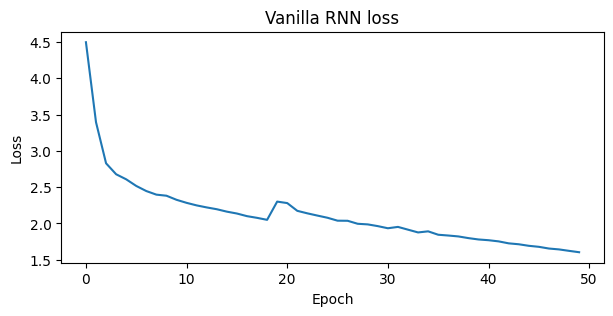

In [34]:
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
# Построим график потерь в зависимости от эпохи
ax.plot(history.history['loss'])
ax.set_title('Vanilla RNN loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [35]:
# Создаем новую модель
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_lstm.add(LSTM(
    rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer='glorot_uniform'))
model_lstm.add(Dense(vocab_size))

In [48]:
# Скомпелируем модель
model_lstm.compile(optimizer='adam', 
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Обучим модель
history = model_lstm.fit(dataset, epochs=50)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - loss: 1.3442
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 1.1991
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 1.1517
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 1.1361
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 1.1058
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 1.0788
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 1.0483
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 1.0263
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.9959
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.9661
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.9375
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.9170
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.8824
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.8541
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.8265
Epoch 16/50
21/21 ━

В итоге модель была дообучена еще на 50 эпохах, в итоге 100 эпох.

In [56]:
# Также сохраним веса
model_lstm.save_weights('model/lstm_onegin.weights.h5')

# Посмотрим на сгенерированный текст и узнаем, что эта модель думает о любви
generated_text = generate_text('lstm', "любовь это", 0.5, 200)
print(generated_text)

любовь это сталого себя;
между тем луна сиялась их добеды
сегом данные часы
опреданный сей кольком,
совести горя лекариты
про зале друга, каж тем кусты,
и смело всех в сей не свят,
и слышен говор ключевой, —
то


Plot the loss function of the number of epochs. Does the final loss become better?

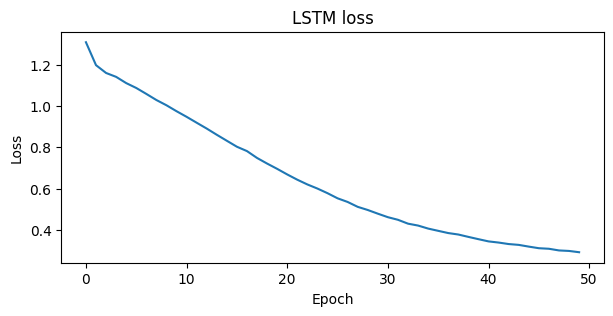

In [53]:
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
# Построим график потерь в зависимости от эпохи
ax.plot(history.history['loss'])
ax.set_title('LSTM loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.show()

Вторая модель (LSTM) имеет преимущества по сравнению с первой (vanila_RNN), она обучалась 100 эпох, когда первая обучилась на 50, но тем не менее результаты второй модели на 50 эпохах в плане функции потерь лучше, чем у первой.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [46]:
print('Text generated by Vanilla RNN')
print('<><><><><><><><><><><><>')

generated_text = generate_text('vanilla_rnn', "любовь это", 0.1, 200)
print('Generated text with 0.1 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "любовь это", 0.2, 200)
print('Generated text with 0.2 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "любовь это", 1.0, 200)
print('Generated text with 1.0 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('vanilla_rnn', "любовь это", 2.0, 200)
print('Generated text with 2.0 temprature:')
print(generated_text)
print('-----------------------')

Text generated by Vanilla RNN
<><><><><><><><><><><><>
Generated text with 0.1 temprature:
любовь этой
прости, весна в ней не забыть, полного с ней
на стол под ней не замечал и своей.



xxxvii

но в ней не замечал мой она встретить не под себя не подруга
и в сад сердце на старый страстей.



xxxii


-----------------------
Generated text with 0.2 temprature:
любовь этой
перед ним не своей подруга
меня пред ним приятно на света,
в глуши молодой,
и в сердце в ней не потом
старушка в сад себя приветство подавал.



xxxii

всё без приятно был пора,
пора мне сердце наде
-----------------------
Generated text with 1.0 temprature:
любовь это:
ув-стал покаину и пехвыл
смеды не хорялась сердца татьяна глада,
в то змартый сад и глоба ты, покрывыть;
я шутичиские пыстромный,
и воздею взник хорою проступает
как отцворе, горыпи зимой.
помой бог
-----------------------
Generated text with 2.0 temprature:
любовь это,;
до, –мы даить угнал удлурqя,
та, даш… та!
но язхижу.
ле«лсица ждину элкю,
mlviя хол

In [55]:
print('Text generated by LSTM')
print('<><><><><><><><><><><><>')

generated_text = generate_text('lstm', "любовь это", 0.1, 200)
print('Generated text with 0.1 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "любовь это", 0.2, 200)
print('Generated text with 0.2 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "любовь это", 1.0, 200)
print('Generated text with 1.0 temprature:')
print(generated_text)
print('-----------------------')

generated_text = generate_text('lstm', "любовь это", 2.0, 200)
print('Generated text with 2.0 temprature:')
print(generated_text)
print('-----------------------')

Text generated by LSTM
<><><><><><><><><><><><>
Generated text with 0.1 temprature:
любовь это странным снем
на воспоминаний ли явленье,
весна, весна! пора любви!
какое томное вставал
совершит о столом душа,
провелев, томный беспечно,
а мать замечает смиренной
на воспоминаний ли явленье,
весна
-----------------------
Generated text with 0.2 temprature:
любовь это стремлюсь не мог
beef-steaks и сменить славой,
там и слыша в смятенье своей.



xiv

так мольно в нем и то же лет». —
«да как в душе своего приятелься в семьей садой
теперь я слез был полон томный
в 
-----------------------
Generated text with 1.0 temprature:
любовь этом мне богат,
и где ж его была соседа;
двойные кажелы,
невзним сердце исполвить,
он ольгаю; старогу ль в мал; дву долг.



xvii

«так ты два мысли обветашье
в сем слушает долено
так несчитью тани;
«ну,
-----------------------
Generated text with 2.0 temprature:
любовь это незнакомы,
когда бразды. хоз мe-se rtyrpt – и вот». —
«мой шюбов, или брать,
ктя idv danstдv

Вторая модель выдает более осмысленные тексты, слова больше похожи на реальные слова, даже в 50 эпохах, именно поэтому я приняла решение дообучить LSTM на еще 50 эпохах. С увеличением температуры в обеих моделях текст становится более хаотичным, с ьемпературой 0.1 модель периодически "заклинивает" на одних и тех же словах и она повторяет их.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [41]:
# Сохраним и загрузим наши получившиеся модели
model_vanilla_rnn.save('model/vanilla_rnn_onegin.keras')
loaded_vanilla_rnn = tf.keras.models.load_model('model/vanilla_rnn_onegin.keras')

model_lstm.save('model/lstm_onegin.keras')
loaded_lstm = tf.keras.models.load_model('model/lstm_onegin.keras')

In [42]:
# Проверим корректность загруки модели
loaded_vanilla_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (64, 100, 1024)        │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 100, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,254,203 (16.23 MB)

 Trainable params: 1,418,067 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,836,136 (10.82 MB)

In [43]:
# Проверим корректность загруки модели
loaded_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (64, 100, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 100, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 100, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,059,899 (61.26 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,706,600 (40.84 MB)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)